# <center> **Master Thesis**
# <center> “Detecting Fake News in Social Networks using ML/DL”
### <center> (2022-2023)

## <center> Álvaro Camiña Magro
## <center> Alfonso Sánchez Macián
### <center> *Puerta de Toledo, 2023*

## Initial libraries and importing data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
from IPython.display import display
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import regex as re
import matplotlib.pyplot as plt
import statistics
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Dense,Input, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from keras.utils import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from transformers import BertTokenizerFast, TFBertModel, RobertaTokenizerFast, TFRobertaModel
from collections import Counter
from sklearn.utils import shuffle
import sentencepiece
from transformers import XLNetTokenizer, XLNetModel
from IPython.display import display, HTML
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from transformers import AutoTokenizer
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df1 = pd.read_csv('/Users/alvarocaminamagro/Documents/Datasets_estudio/fake.csv', delimiter=',')
df1.dataframeName = 'fake.csv'
df2 = pd.read_csv('/Users/alvarocaminamagro/Documents/Datasets_estudio/real.csv', delimiter=',')
df2.dataframeName = 'real.csv'

In [ ]:
df1.shape

(19999, 1)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19999 entries, 0 to 19998
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   19988 non-null  object
dtypes: object(1)
memory usage: 156.4+ KB


In [ ]:
df2.shape

(21869, 1)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21869 entries, 0 to 21868
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   21863 non-null  object
dtypes: object(1)
memory usage: 171.0+ KB


## Preprocessing

In [ ]:
df1.iloc[88]

tweet    saudi defense is mighty\nthey hit them with in...
Name: 88, dtype: object

In [ ]:
null_counts = df1.isnull().sum()
print(null_counts)

tweet    11
dtype: int64


In [ ]:
null_counts = df2.isnull().sum()
print(null_counts)

tweet    6
dtype: int64


In [ ]:
df1 = df1.dropna()
df2 = df2.dropna()

In [ ]:
df1 = df1.reset_index()
df2 = df2.reset_index()

null_counts = df1.isnull().sum()
print(null_counts)
null_counts = df2.isnull().sum()
print(null_counts)

index    0
tweet    0
dtype: int64
index    0
tweet    0
dtype: int64


In [ ]:
df1['type'] = 'fake'
df2['type'] = 'real'
df = pd.concat([df1, df2], ignore_index=True, sort = 'False')
df = df.reset_index()

In [ ]:
df.head()

,level_0,index,tweet,type
0,0,0,"the tongue of his condition, now i saw things ...",fake
1,1,1,"by god the great, after i saw the derby of wyd...",fake
2,2,2,"believe in god, this zamalek fans are as good ...",fake
3,3,3,the coach appeared in the media and told the t...,fake
4,4,4,asno smito\nwhoever knows her tells me a massa...,fake


In [ ]:
df = df.drop(columns=['level_0', 'index'], axis =1)

Text(0.5, 1.0, 'The distribution of real and fake tweets')

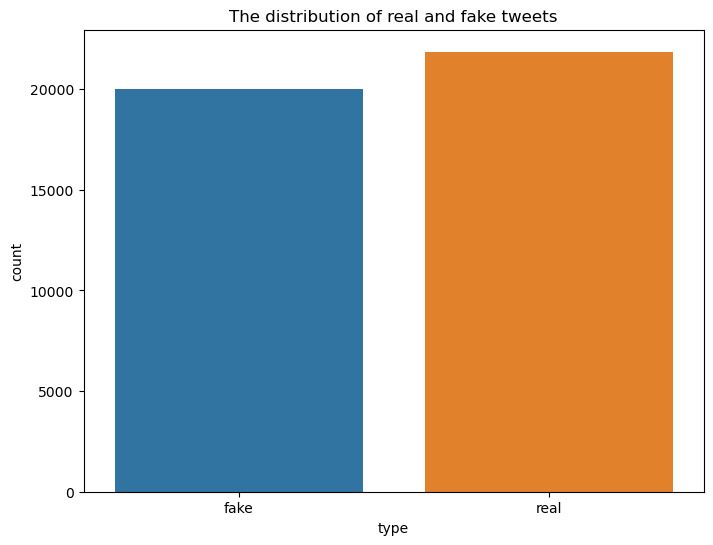

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='type')
plt.title('The distribution of real and fake tweets')

## EDA

### Corpus definition

In [ ]:
print(df['tweet'][0])

the tongue of his condition, now i saw things that confused you, shame on you, i am not young haha # tarek_hamed_tafah_kila 


In [ ]:
# Preprocess the text data
def preprocess_text(text):
    # Clean the text
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.lower()
    text = re.sub(r'\b(ha)+\b', '', text)
    text = text.replace('\n', ' ')

    return text.strip()

def tokenize_column(df, column):
    # create an empty list to store the tokenized text
    tokenized = []

    # iterate over each row in the specified column
    for idx, row in df.iterrows():
        # tokenize the text in the specified column
        tokens = word_tokenize(row[column])

        # remove stopwords from the tokenized text
        filtered_tokens = [x for x in tokens if x not in stopwords.words('english')]

        # join the filtered tokens back into a single string and append to the tokenized list
        tokenized.append(' '.join(filtered_tokens))

    # add the tokenized text as a new column to the DataFrame
    df['tokenized'] = tokenized

    # return the modified DataFrame
    return df

df['cleaned']=df['tweet'].apply(preprocess_text)

df = tokenize_column(df, 'cleaned')

df.head()

,tweet,type,cleaned,tokenized
0,"the tongue of his condition, now i saw things ...",fake,the tongue of his condition now i saw things t...,tongue condition saw things confused shame you...
1,"by god the great, after i saw the derby of wyd...",fake,by god the great after i saw the derby of wyda...,god great saw derby wydad al raja al maghribi ...
2,"believe in god, this zamalek fans are as good ...",fake,believe in god this zamalek fans are as good a...,believe god zamalek fans good swear god celebr...
3,the coach appeared in the media and told the t...,fake,the coach appeared in the media and told the t...,coach appeared media told truth got told swear...
4,asno smito\nwhoever knows her tells me a massa...,fake,asno smito whoever knows her tells me a massag...,asno smito whoever knows tells massage whoever...


### Wordclouds

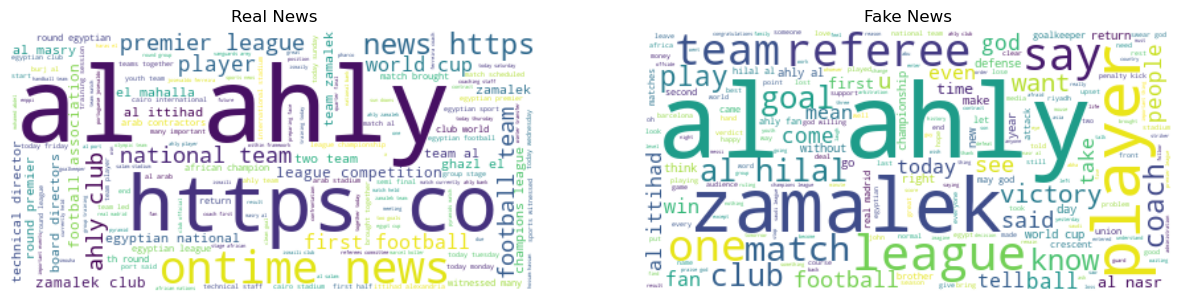

In [ ]:
df_corpus = df
df_corpus['tweet'] = df_corpus['tokenized']

real_text = ' '.join(df_corpus[df_corpus['type']=='real']['tweet'].tolist())
fake_text = ' '.join(df_corpus[df_corpus['type']=='fake']['tweet'].tolist())

real_wordcloud = WordCloud(background_color='white').generate(real_text)
fake_wordcloud = WordCloud(background_color='white').generate(fake_text)

plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Real News')

plt.subplot(1, 2, 2)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News')

plt.show()

### Top 20 common words

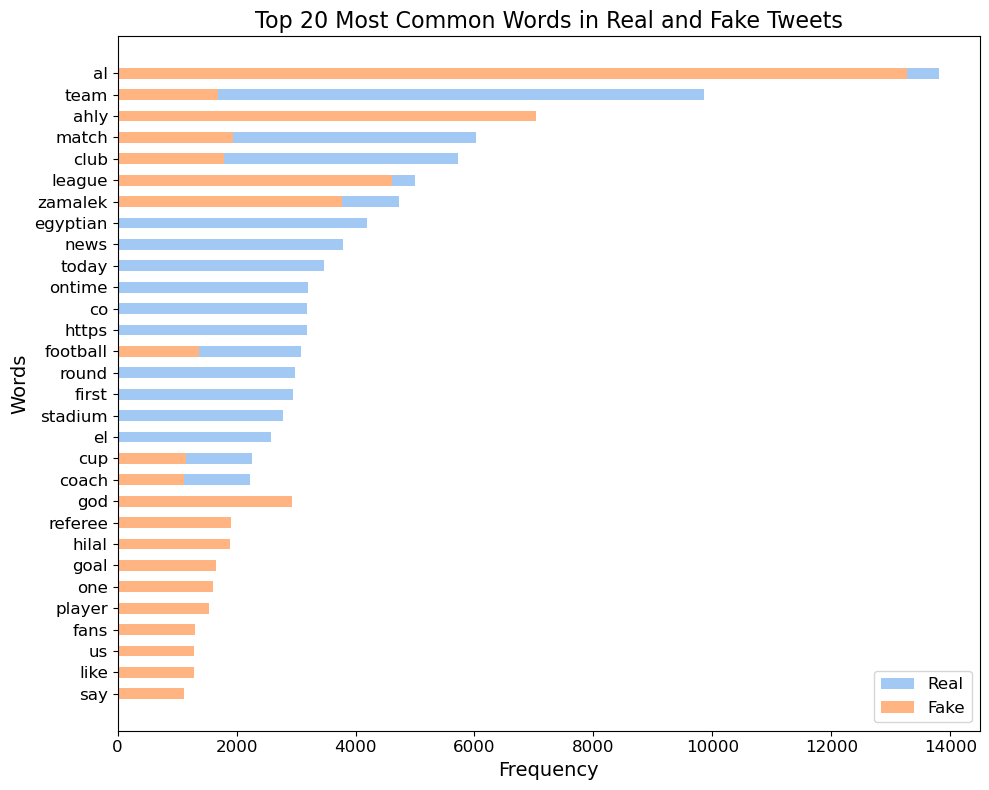

In [ ]:
colors = sns.color_palette('pastel', 2)

real_words = Counter(real_text.split()).most_common(20)
fake_words = Counter(fake_text.split()).most_common(20)

plt.figure(figsize=(10, 8))
plt.barh([x[0] for x in real_words], [x[1] for x in real_words], height=0.5, color= colors[0], label='Real')
plt.barh([x[0] for x in fake_words], [x[1] for x in fake_words], height=0.5, color= colors[1], label='Fake')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('Top 20 Most Common Words in Real and Fake Tweets', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Analisis of the text length

In [ ]:
df['tweet_length']=df['tokenized'].apply(lambda x: len(x))

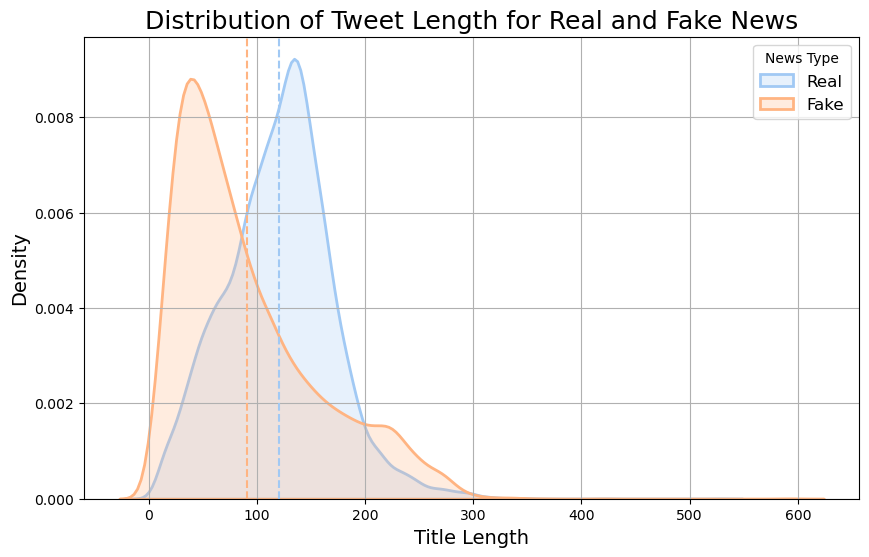

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_corpus[df_corpus['type'] == 'real']['tweet_length'], color= colors[0], fill=True, label='Real', linewidth=2)
sns.kdeplot(df_corpus[df_corpus['type'] == 'fake']['tweet_length'], color= colors[1], fill=True, label='Fake', linewidth=2)
plt.axvline(df_corpus[df_corpus['type'] == 'real']['tweet_length'].mean(), color= colors[0], linestyle='--')
plt.axvline(df_corpus[df_corpus['type'] == 'fake']['tweet_length'].mean(), color= colors[1], linestyle='--')
plt.xlabel('Title Length', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='News Type', fontsize=12, labels=['Real', 'Fake'])
plt.title('Distribution of Tweet Length for Real and Fake News', fontsize=18)
plt.grid()
plt.show()

## Test/train partition and ML tecniques

In [ ]:
X3=df['tokenized']
y3=df['type']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X3 ,y3, test_size=0.20, random_state = 777)

In [ ]:
def print_errors_report(df, X_test, y_test, y_pred):
    df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': y_pred})
    misclassified_idx = df['true_label'] != df['predicted_label']
    misclassified = df[misclassified_idx]
    table = misclassified[['true_label', 'predicted_label', 'text']].reset_index(drop=True)
    table_styled = table.style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
    print("Misclassified examples:")
    display(table_styled.data.head(20))

def run_model(dataset, model, X_train, y_train, X_test, y_test, param_grid, cv=5):
    # create a TfidfVectorizer object to convert text to numerical features
    tfidf = TfidfVectorizer()

    # convert text data to numerical features
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    # perform a grid search with cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    grid_search.fit(X_train_tfidf, y_train)

    # use the best model to make predictions on the test data
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test_tfidf)

    # print the classification report
    print("=" * 50)
    print("Classification Report for", model.__class__.__name__)
    print("=" * 50)
    print(" " * 50)
    print(classification_report(y_test, y_pred))

    print(" " * 50)
    print(" " * 50)

    print("=" * 50)
    print("Best hyperparameters for", model.__class__.__name__)
    print("=" * 50)
    print(" " * 50)

    # print the best estimator and its score on the test data
    score = grid_search.best_score_
    accuracy = best_estimator.score(X_test_tfidf, y_test)
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best score:",score)
    print("Accuracy on test set:", accuracy)

    print(" " * 50)
    print(" " * 50)

    print("=" * 50)
    print("Confusion matrix and ROC curve for", model.__class__.__name__)
    print("=" * 50)
    print(" " * 50)

    # create a confusion matrix and plot it in the first subplot
    cm = confusion_matrix(y_test, y_pred)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap="Blues", ax=ax1)
    ax1.set_xlabel("Predicted Labels")
    ax1.set_ylabel("True Labels")
    ax1.set_title("Confusion Matrix")


    # plot the ROC curve in the second subplot
    RocCurveDisplay.from_estimator(best_estimator, X_test_tfidf, y_test, ax=ax2)
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')

    # adjust the layout and show the figure
    plt.tight_layout()
    plt.show()

    print(" " * 50)
    print(" " * 50)

    print("=" * 50)
    print("Misclassified examples for", model.__class__.__name__)
    print("=" * 50)
    print(" " * 50)

    print_errors_report(dataset, X_test, y_test, y_pred)

    print(" " * 50)
    print(" " * 50)

    return accuracy, y_pred, best_estimator

### SVM

Classification Report for SVC
                                                  
              precision    recall  f1-score   support

        fake       0.94      0.96      0.95      3980
        real       0.97      0.94      0.96      4391

    accuracy                           0.95      8371
   macro avg       0.95      0.95      0.95      8371
weighted avg       0.95      0.95      0.95      8371

                                                  
                                                  
Best hyperparameters for SVC
                                                  
Best hyperparameters: {'C': 10, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
Best score: 0.9513142174432498
Accuracy on test set: 0.9537689642814479
                                                  
                                                  
Confusion matrix and ROC curve for SVC
                                                  


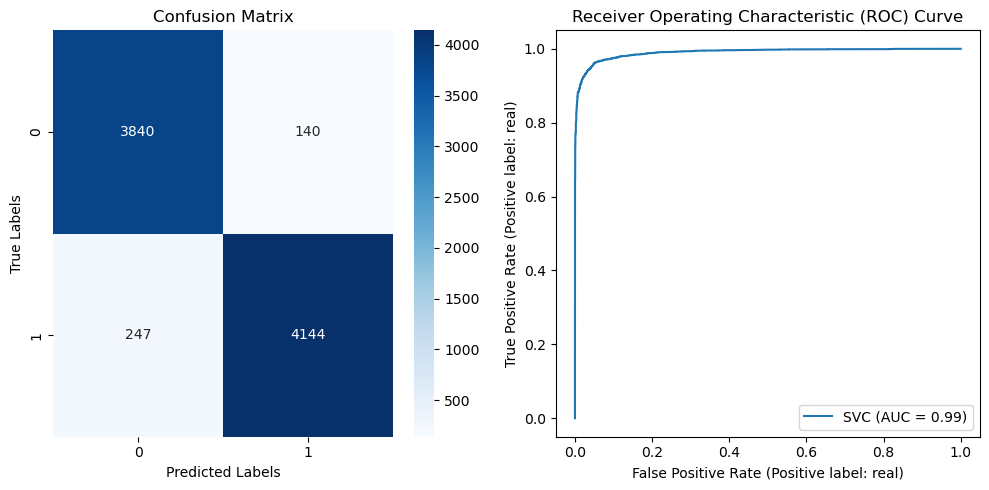

                                                  
                                                  
Misclassified examples for SVC
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,fake,real,getafe scored goals throughout season records ...
1,fake,real,ahmed el shennawy correct penalty kick smouha ...
2,fake,real,riyadh seasonani wish would focus team focuses...
3,fake,real,psychology depends today al ahly match god lor...
4,real,fake,amazing thing zamalek players renewing know va...
5,fake,real,carteron coach zamalek
6,real,fake,amir mortada mansour seek reconcile fans win l...
7,real,fake,hamada tolba hope zamalek wins league title
8,real,fake,stanley contract qadisiyah expired leave club
9,fake,real,zamalek team left caf champions league group s...


In [ ]:
# define the SVM classifier
svm = SVC()

param_grid = {'kernel': ['linear', 'rbf'],
              'C': [0.1, 1, 10],
              'gamma': [0.1, 1],
              'class_weight': [None, 'balanced']}

# train and evaluate the model
accuracy_svm, y_pred_svm, svm = run_model(df, svm, X_train, y_train, X_test, y_test, param_grid)

### MultinomialNB

Classification Report for MultinomialNB
                                                  
              precision    recall  f1-score   support

        fake       0.92      0.95      0.94      3980
        real       0.96      0.92      0.94      4391

    accuracy                           0.94      8371
   macro avg       0.94      0.94      0.94      8371
weighted avg       0.94      0.94      0.94      8371

                                                  
                                                  
Best hyperparameters for MultinomialNB
                                                  
Best hyperparameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': False}
Best score: 0.9366786140979689
Accuracy on test set: 0.9372834786763827
                                                  
                                                  
Confusion matrix and ROC curve for MultinomialNB
                                                  


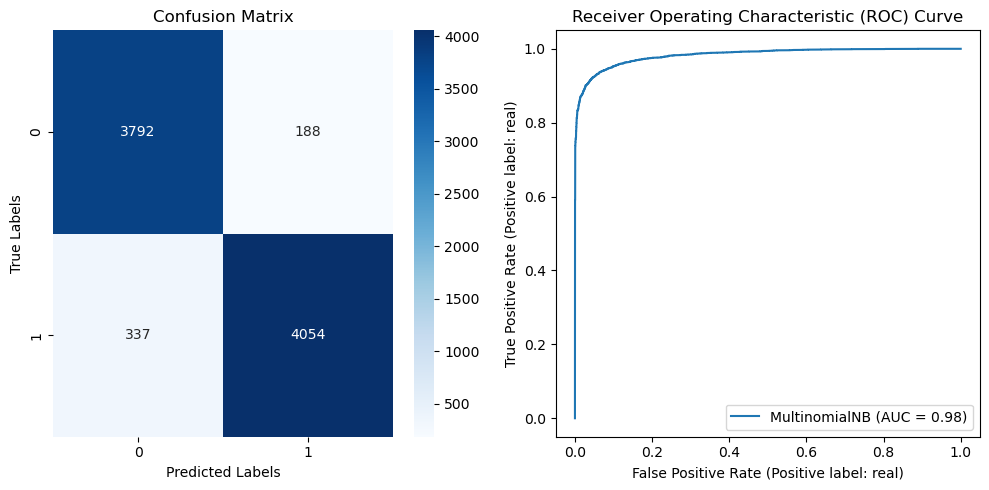

                                                  
                                                  
Misclassified examples for MultinomialNB
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,real,fake,hope second half completely forgets disastrous...
1,real,fake,amazing thing zamalek players renewing know va...
2,fake,real,carteron coach zamalek
3,fake,real,zamalek team left caf champions league group s...
4,real,fake,great management captain hussein labib meeting...
5,fake,real,tomorrow god willing al ahly zamalek match pos...
6,real,fake,ahmed diab real accurate number clubs contract...
7,real,fake,one bereaved speaks slain killed sake god come...
8,fake,real,achievement egyptian national team end legend ...
9,real,fake,question remains guaranteeing riyal win


In [ ]:
# define the MultinomialNB classifier
nb = MultinomialNB()

param_grid = {'alpha': [0.1, 1, 10],
              'fit_prior': [True, False],
              'class_prior': [None, [0.3, 0.7], [0.4, 0.6]]}


# train and evaluate the model
accuracy_nb, y_pred_nb, nb = run_model(df, nb, X_train, y_train, X_test, y_test,param_grid)

### RandomForestClassifier

Classification Report for RandomForestClassifier
                                                  
              precision    recall  f1-score   support

        fake       0.93      0.95      0.94      3980
        real       0.95      0.93      0.94      4391

    accuracy                           0.94      8371
   macro avg       0.94      0.94      0.94      8371
weighted avg       0.94      0.94      0.94      8371

                                                  
                                                  
Best hyperparameters for RandomForestClassifier
                                                  
Best hyperparameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.936499402628435
Accuracy on test set: 0.9395532194480947
                                                  
                                                  
Confusion matrix and ROC curve for RandomForestClassifier
          

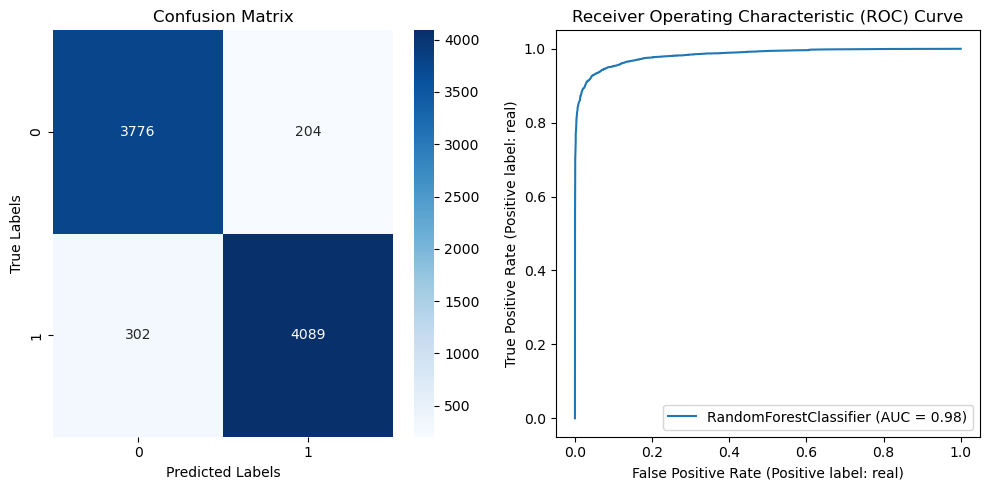

                                                  
                                                  
Misclassified examples for RandomForestClassifier
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,fake,real,ahmed el shennawy correct penalty kick smouha ...
1,fake,real,riyadh seasonani wish would focus team focuses...
2,real,fake,return fans stadiums
3,real,fake,amazing thing zamalek players renewing know va...
4,fake,real,carteron coach zamalek
5,fake,real,fadel leagues cups local supers african champi...
6,real,fake,amir mortada mansour seek reconcile fans win l...
7,real,fake,hamada tolba hope zamalek wins league title
8,real,fake,stanley contract qadisiyah expired leave club
9,fake,real,zamalek team left caf champions league group s...


In [ ]:
# create a Random Forest object
rf = RandomForestClassifier(random_state=777)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2, 6],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

# train and evaluate the model
accuracy_rf, y_pred_rf, rf = run_model(df, rf, X_train, y_train, X_test, y_test, param_grid)

### LogisticRegression

Classification Report for LogisticRegression
                                                  
              precision    recall  f1-score   support

        fake       0.93      0.96      0.94      3980
        real       0.96      0.93      0.95      4391

    accuracy                           0.94      8371
   macro avg       0.94      0.94      0.94      8371
weighted avg       0.94      0.94      0.94      8371

                                                  
                                                  
Best hyperparameters for LogisticRegression
                                                  
Best hyperparameters: {'C': 1, 'class_weight': 'balanced', 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.001}
Best score: 0.9416965352449225
Accuracy on test set: 0.9433759407478198
                                                  
                                                  
Confusion matrix and ROC curve for LogisticRegressio

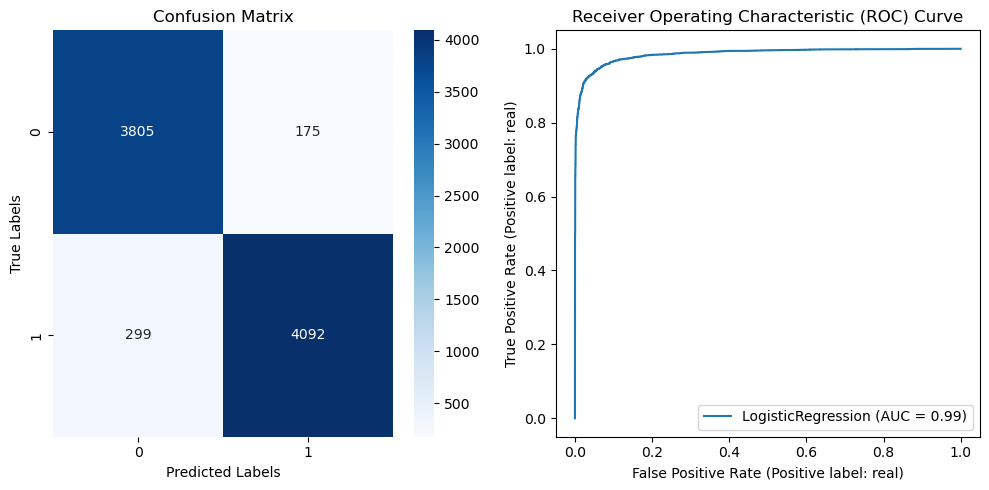

                                                  
                                                  
Misclassified examples for LogisticRegression
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,fake,real,getafe scored goals throughout season records ...
1,fake,real,ahmed el shennawy correct penalty kick smouha ...
2,real,fake,return fans stadiums
3,real,fake,amazing thing zamalek players renewing know va...
4,real,fake,amir mortada mansour seek reconcile fans win l...
5,real,fake,hamada tolba hope zamalek wins league title
6,fake,real,zamalek team left caf champions league group s...
7,real,fake,one bereaved speaks slain killed sake god come...
8,fake,real,congratulations al ahly egypt finished second ...
9,fake,real,toughest game season weak management whole tea...


In [ ]:
# create a Logistic Regression object
lr = LogisticRegression()

param_grid = {
    'C': [0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 500],
    'tol': [1e-3, 1e-4]
}

# train and evaluate the model
accuracy_lr, y_pred_lr, lr = run_model(df, lr, X_train, y_train, X_test, y_test, param_grid)

### GradientBoostingClassifier

Classification Report for GradientBoostingClassifier
                                                  
              precision    recall  f1-score   support

        fake       0.85      0.93      0.89      3980
        real       0.93      0.85      0.89      4391

    accuracy                           0.89      8371
   macro avg       0.89      0.89      0.89      8371
weighted avg       0.89      0.89      0.89      8371

                                                  
                                                  
Best hyperparameters for GradientBoostingClassifier
                                                  
Best hyperparameters: {'learning_rate': 0.1, 'loss': 'log_loss', 'n_estimators': 200}
Best score: 0.8834229390681003
Accuracy on test set: 0.887707561820571
                                                  
                                                  
Confusion matrix and ROC curve for GradientBoostingClassifier
                                           

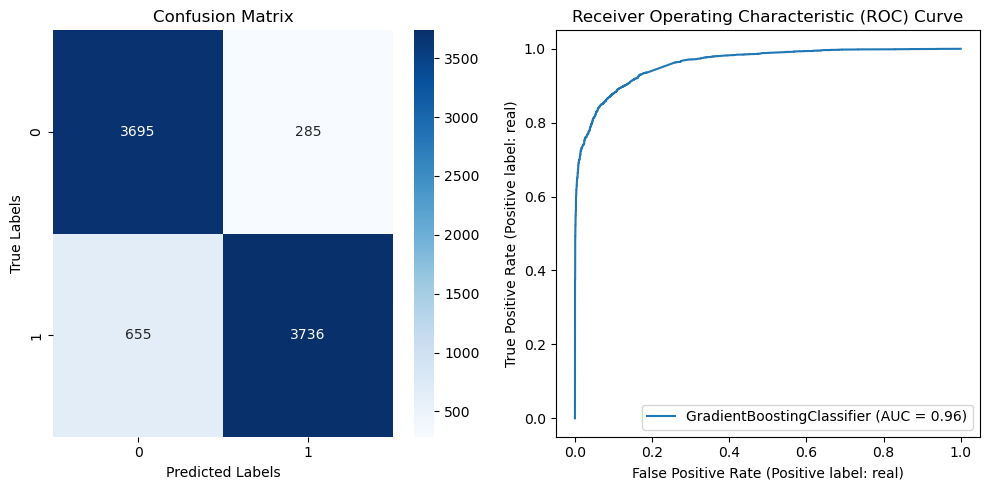

                                                  
                                                  
Misclassified examples for GradientBoostingClassifier
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,real,fake,jihad greisha former international referee con...
1,real,fake,dr ashraf sobhi minister youth sports keen par...
2,fake,real,ahmed el shennawy correct penalty kick smouha ...
3,fake,real,wish praise father five al ahly took sundowns ...
4,real,fake,white knight preparing face ghazl al mahalla a...
5,real,fake,emad miteb holds session abdel hafeez discuss ...
6,fake,real,riyadh seasonani wish would focus team focuses...
7,real,fake,return fans stadiums
8,real,fake,amazing thing zamalek players renewing know va...
9,real,fake,clearing turns delay ghaly victory dervishes


In [ ]:
# define the Gradient Boosting classifier object
gb = GradientBoostingClassifier(random_state=777)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'loss': ['log_loss', 'exponential']
}

# train and evaluate the model
accuracy_gb, y_pred_gb, gb = run_model(df, gb, X_train, y_train, X_test, y_test, param_grid)

### KNeighborsClassifier

Classification Report for KNeighborsClassifier
                                                  
              precision    recall  f1-score   support

        fake       0.91      0.91      0.91      3980
        real       0.92      0.92      0.92      4391

    accuracy                           0.91      8371
   macro avg       0.91      0.91      0.91      8371
weighted avg       0.91      0.91      0.91      8371

                                                  
                                                  
Best hyperparameters for KNeighborsClassifier
                                                  
Best hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'cosine', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best score: 0.9110812425328554
Accuracy on test set: 0.9142276908374148
                                                  
                                                  
Confusion matrix and ROC curve for KNeighborsClassifier
                

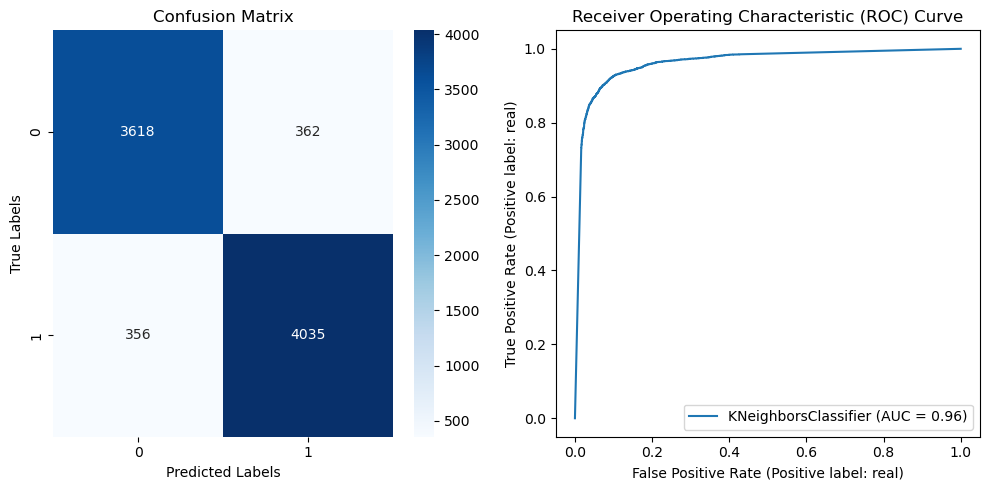

                                                  
                                                  
Misclassified examples for KNeighborsClassifier
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,fake,real,zoran motallib put muhammad bin faisal zoran l...
1,fake,real,ahmed el shennawy correct penalty kick smouha ...
2,fake,real,saw attack focused tv following sitting said o...
3,real,fake,mohamed ibrahim participated national team u w...
4,fake,real,psychology depends today al ahly match god lor...
5,real,fake,amazing thing zamalek players renewing know va...
6,real,fake,clearing turns delay ghaly victory dervishes
7,fake,real,carteron coach zamalek
8,real,fake,amir mortada mansour seek reconcile fans win l...
9,real,fake,stanley contract qadisiyah expired leave club


In [ ]:
# create a KNN object
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [3, 5],
              'weights': ['uniform', 'distance'],
              'p': [1, 2],
              'algorithm': ['auto', 'ball_tree'],
              'leaf_size': [10, 20],
              'metric': ['minkowski', 'cosine']}

# train and evaluate the model
accuracy_knn, y_pred_knn, knn = run_model(df, knn, X_train, y_train, X_test, y_test, param_grid)

### Pasive Agressive Classifier

Classification Report for PassiveAggressiveClassifier
                                                  
              precision    recall  f1-score   support

        fake       0.94      0.95      0.95      3980
        real       0.96      0.94      0.95      4391

    accuracy                           0.95      8371
   macro avg       0.95      0.95      0.95      8371
weighted avg       0.95      0.95      0.95      8371

                                                  
                                                  
Best hyperparameters for PassiveAggressiveClassifier
                                                  
Best hyperparameters: {'C': 0.01, 'early_stopping': False, 'fit_intercept': True, 'loss': 'hinge', 'max_iter': 100, 'shuffle': True, 'tol': 0.0001, 'validation_fraction': 0.2}
Best score: 0.9462066905615293
Accuracy on test set: 0.9481543423724764
                                                  
                                                  
Confusion ma

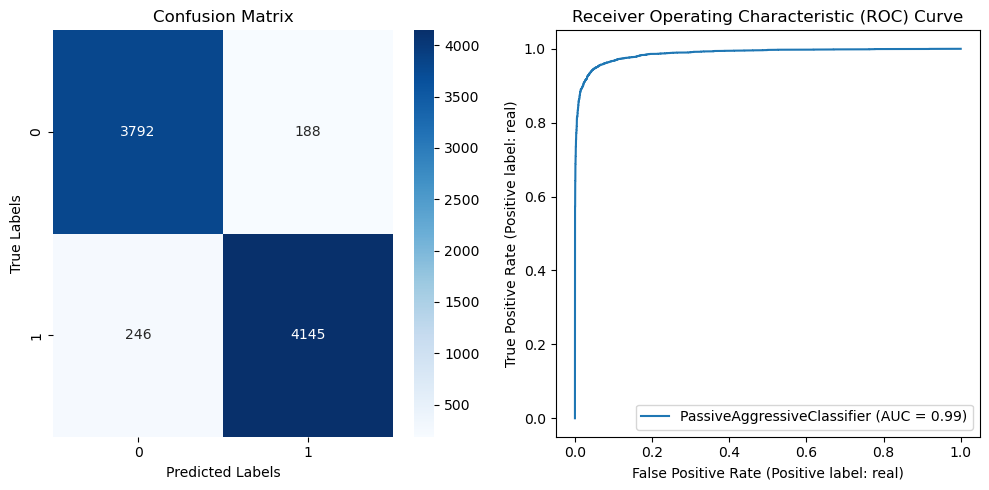

                                                  
                                                  
Misclassified examples for PassiveAggressiveClassifier
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,fake,real,getafe scored goals throughout season records ...
1,fake,real,ahmed el shennawy correct penalty kick smouha ...
2,fake,real,riyadh seasonani wish would focus team focuses...
3,fake,real,psychology depends today al ahly match god lor...
4,real,fake,return fans stadiums
5,real,fake,amazing thing zamalek players renewing know va...
6,fake,real,carteron coach zamalek
7,real,fake,stanley contract qadisiyah expired leave club
8,fake,real,zamalek team left caf champions league group s...
9,real,fake,one bereaved speaks slain killed sake god come...


In [ ]:
# Create a PassiveAggressiveClassifier model
pac = PassiveAggressiveClassifier()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 1000, 10000],
    'tol': [1e-4, 1e-5],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'loss': ['hinge', 'squared_hinge'],
    'early_stopping': [True, False],
    'validation_fraction': [0.1, 0.2],
}

# train and evaluate the model
accuracy_pac, y_pred_pac, pac = run_model(df, pac, X_train, y_train, X_test, y_test,param_grid)

### Results

In [ ]:
results_dict = {'SVM': {'accuracy': accuracy_svm},
'Random Forest': {'accuracy': accuracy_rf},
'Naive Bayes': {'accuracy': accuracy_nb},
'Logistic Regression': {'accuracy': accuracy_lr},
'Gradient Boosting': {'accuracy': accuracy_gb},
'K-Nearest Neighbors': {'accuracy': accuracy_knn},
'Passive Agressive clasifier': {'accuracy': accuracy_pac}}

results_df = pd.DataFrame(results_dict).transpose().sort_values('accuracy', ascending=False)

display(HTML(results_df.to_html()))

,accuracy
SVM,0.953769
Passive Agressive clasifier,0.948154
Logistic Regression,0.943376
Random Forest,0.939553
Naive Bayes,0.937283
K-Nearest Neighbors,0.914228
Gradient Boosting,0.887708


## Attention models

In [ ]:
sentences = df_corpus['tokenized'].astype(str).str.lower().values.tolist()

labels = df_corpus['type'].values.tolist()

labels = np.array([1 if label == "fake" else 0 for label in labels])

# Shuffle the sentences and labels together
shuffled_sentences, shuffled_labels = shuffle(sentences, labels, random_state=42)
len(shuffled_sentences)

41851

In [ ]:
# Split the data into train and test sets, maintaining the class proportions
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(
    shuffled_sentences, shuffled_labels, test_size=0.2, stratify=shuffled_labels, random_state=42
)

# Check the lengths of the train and test sets
print("Train set length:", len(training_sentences))
print("Test set length:", len(testing_sentences))

Train set length: 33480
Test set length: 8371


In [ ]:
#Hyper parameters

vocab_size = 10000
embedding_dim = 40
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
print('The total words are ', len(word_index))

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

The total words are  23538


In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

### LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

2023-06-23 04:57:58.595100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 04:57:58.596860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 04:57:58.597940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 40)           400000    
                                                                 
 bidirectional (Bidirectiona  (None, 100, 64)          18688     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 24)                1560      
                                                                 
 dropout_1 (Dropout)         (None, 24)                0

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30


2023-06-23 04:57:59.565960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 04:57:59.567211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 04:57:59.568527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1047/1047 - 64s - loss: 0.1938 - accuracy: 0.9226 - val_loss: 0.1368 - val_accuracy: 0.9480 - 64s/epoch - 61ms/step
Epoch 2/30
1047/1047 - 59s - loss: 0.0963 - accuracy: 0.9650 - val_loss: 0.1339 - val_accuracy: 0.9519 - 59s/epoch - 56ms/step
Epoch 3/30
1047/1047 - 61s - loss: 0.0633 - accuracy: 0.9775 - val_loss: 0.1705 - val_accuracy: 0.9464 - 61s/epoch - 58ms/step
Epoch 4/30
1047/1047 - 60s - loss: 0.0471 - accuracy: 0.9834 - val_loss: 0.1855 - val_accuracy: 0.9429 - 60s/epoch - 57ms/step
Epoch 5/30
1047/1047 - 60s - loss: 0.0379 - accuracy: 0.9874 - val_loss: 0.2218 - val_accuracy: 0.9437 - 60s/epoch - 57ms/step
Epoch 6/30
1047/1047 - 60s - loss: 0.0295 - accuracy: 0.9901 - val_loss: 0.3048 - val_accuracy: 0.9421 - 60s/epoch - 57ms/step
Epoch 7/30
1047/1047 - 60s - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.2289 - val_accuracy: 0.9409 - 60s/epoch - 57ms/step
Epoch 8/30
1047/1047 - 60s - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.2796 - val_accuracy: 0.9417 - 60s/epoch - 57ms/

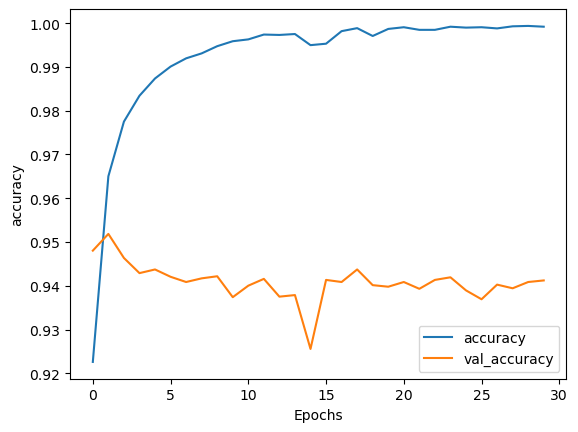

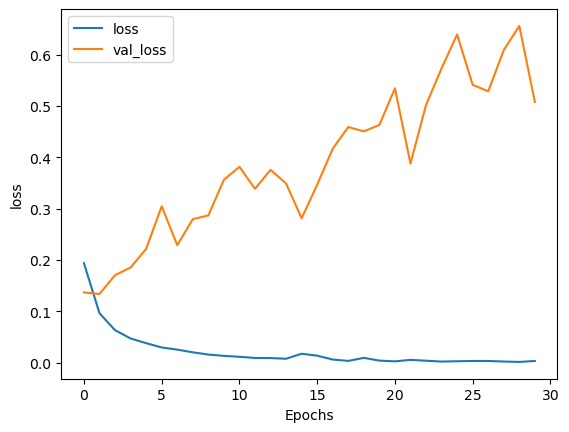

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
lstm_loss, lstm_acc = model.evaluate(testing_padded, testing_labels)

262/262 [==============================] - 3s 13ms/step - loss: 0.5081 - accuracy: 0.9412


2023-06-23 05:28:08.955141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 05:28:08.956382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 05:28:08.957986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

262/262 [==============================] - 5s 13ms/step


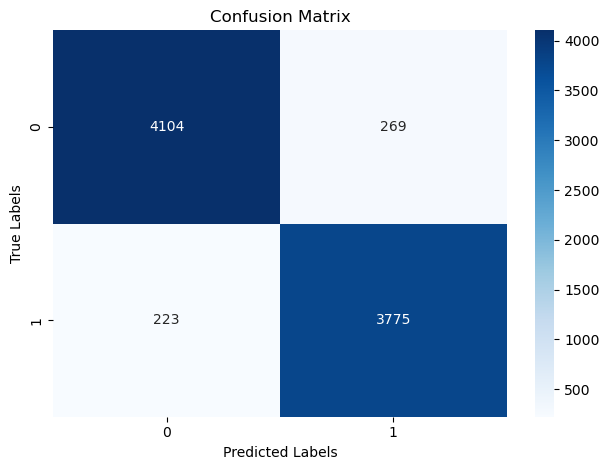

In [ ]:
predicted_probabilities = model.predict(testing_padded)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

confusion_matrix = tf.math.confusion_matrix(testing_labels, predicted_labels)

ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.tight_layout()

plt.show()

262/262 [==============================] - 3s 13ms/step


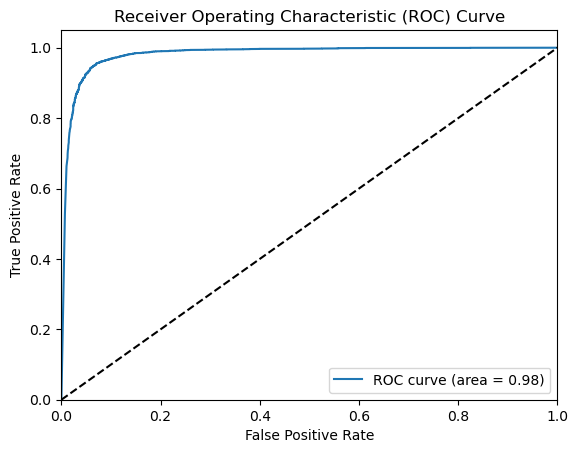

In [ ]:
predicted_probabilities = model.predict(testing_padded)
predicted_labels = (predicted_probabilities > 0.5).astype(int)  # Convert probabilities to binary labels (e.g., using a threshold of 0.5)

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(testing_labels, predicted_probabilities)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot a diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### CNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 40)           400000    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           25728     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
1047/1047 - 8s - loss: 0.2214 - accuracy: 0.9101 - val_loss: 0.1427 - val_accuracy: 0.9460 - 8s/epoch - 8ms/step
Epoch 2/30
1047/1047 - 7s - loss: 0.1005 - accuracy: 0.9654 - val_loss: 0.1421 - val_accuracy: 0.9495 - 7s/epoch - 7ms/step
Epoch 3/30
1047/1047 - 7s - loss: 0.0509 - accuracy: 0.9828 - val_loss: 0.1645 - val_accuracy: 0.9461 - 7s/epoch - 7ms/step
Epoch 4/30
1047/1047 - 8s - loss: 0.0227 - accuracy: 0.9931 - val_loss: 0.2108 - val_accuracy: 0.9479 - 8s/epoch - 7ms/step
Epoch 5/30
1047/1047 - 8s - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.2555 - val_accuracy: 0.9466 - 8s/epoch - 7ms/step
Epoch 6/30
1047/1047 - 8s - loss: 0.0072 - accuracy: 0.9978 - val_loss: 0.3306 - val_accuracy: 0.9458 - 8s/epoch - 7ms/step
Epoch 7/30
1047/1047 - 8s - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.3453 - val_accuracy: 0.9477 - 8s/epoch - 7ms/step
Epoch 8/30
1047/1047 - 8s - loss: 0.0061 - accuracy: 0.9980 - val_loss: 0.3407 - val_accuracy: 0.9459 - 8s/epoch - 7ms/step
Epoch 9/

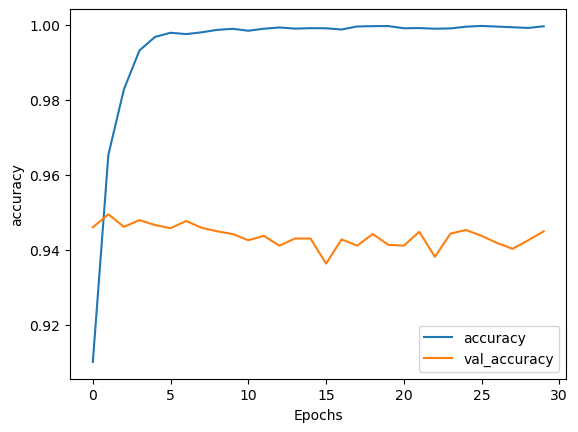

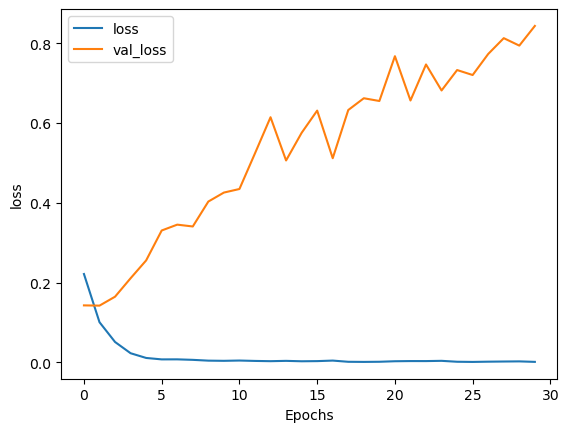

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
cnn_loss, cnn_acc = model.evaluate(testing_padded, testing_labels)

262/262 [==============================] - 1s 2ms/step - loss: 0.8438 - accuracy: 0.9449


262/262 [==============================] - 1s 2ms/step


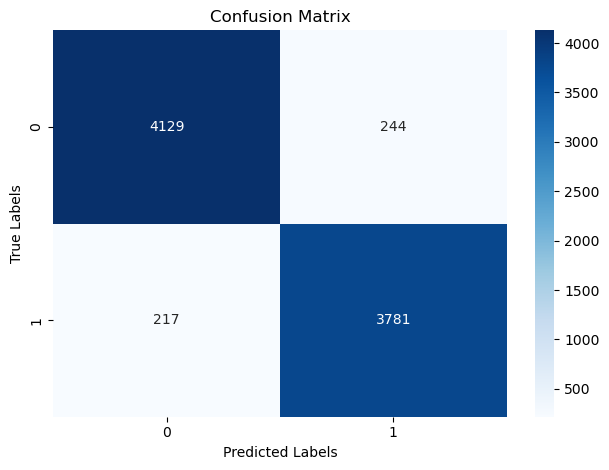

In [ ]:
predicted_probabilities = model.predict(testing_padded)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

confusion_matrix = tf.math.confusion_matrix(testing_labels, predicted_labels)

ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.tight_layout()

plt.show()

262/262 [==============================] - 1s 2ms/step


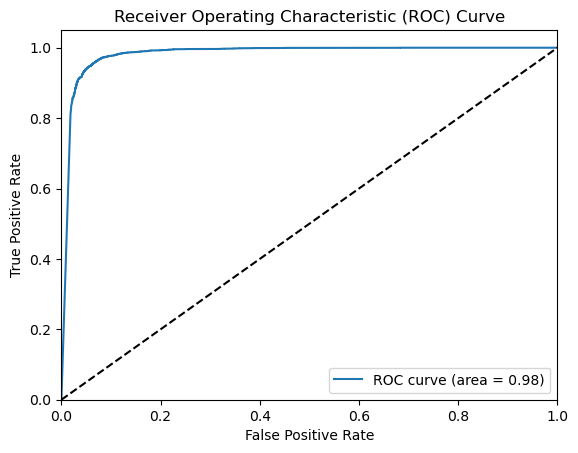

In [ ]:
predicted_probabilities = model.predict(testing_padded)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

fpr, tpr, thresholds = roc_curve(testing_labels, predicted_probabilities)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### BiLSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

2023-06-23 05:32:08.670820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 05:32:08.672006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 05:32:08.673224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 40)           400000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 64)          18688     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
 dropout_4 (Dropout)         (None, 24)               

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30


2023-06-23 05:32:09.572737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-23 05:32:09.574089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-23 05:32:09.575563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1047/1047 - 65s - loss: 0.1980 - accuracy: 0.9221 - val_loss: 0.1416 - val_accuracy: 0.9488 - 65s/epoch - 62ms/step
Epoch 2/30
1047/1047 - 59s - loss: 0.1053 - accuracy: 0.9634 - val_loss: 0.1394 - val_accuracy: 0.9477 - 59s/epoch - 57ms/step
Epoch 3/30
1047/1047 - 59s - loss: 0.0636 - accuracy: 0.9782 - val_loss: 0.1603 - val_accuracy: 0.9490 - 59s/epoch - 57ms/step
Epoch 4/30
1047/1047 - 60s - loss: 0.0490 - accuracy: 0.9833 - val_loss: 0.1825 - val_accuracy: 0.9416 - 60s/epoch - 58ms/step
Epoch 5/30
1047/1047 - 60s - loss: 0.0365 - accuracy: 0.9879 - val_loss: 0.2398 - val_accuracy: 0.9335 - 60s/epoch - 57ms/step
Epoch 6/30
1047/1047 - 59s - loss: 0.0282 - accuracy: 0.9904 - val_loss: 0.2656 - val_accuracy: 0.9382 - 59s/epoch - 57ms/step
Epoch 7/30
1047/1047 - 60s - loss: 0.0238 - accuracy: 0.9920 - val_loss: 0.2971 - val_accuracy: 0.9387 - 60s/epoch - 57ms/step
Epoch 8/30
1047/1047 - 61s - loss: 0.0194 - accuracy: 0.9935 - val_loss: 0.2884 - val_accuracy: 0.9421 - 61s/epoch - 58ms/

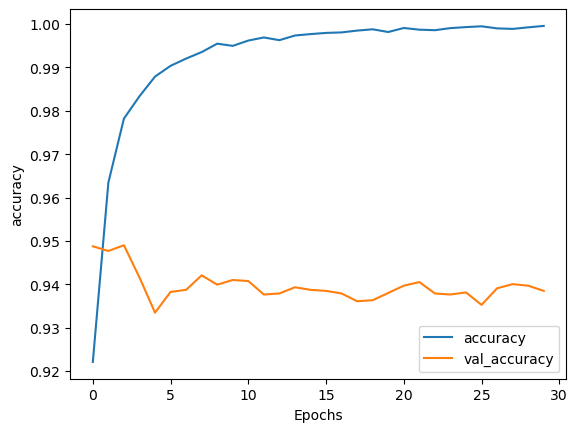

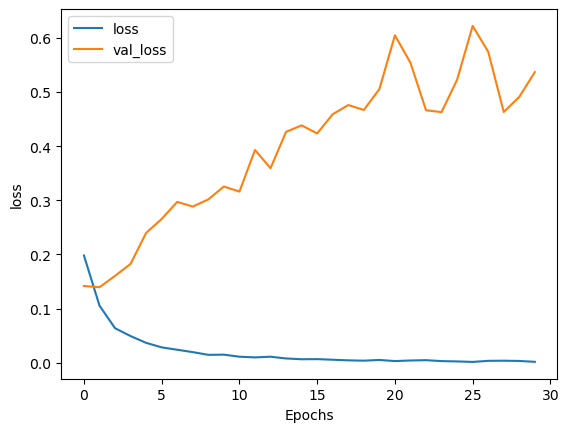

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
bilstm_loss, bilstm_acc = model.evaluate(testing_padded, testing_labels)

262/262 [==============================] - 3s 13ms/step - loss: 0.5371 - accuracy: 0.9385


### RNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 40)           400000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 100, 64)           6720      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 419,201
Trainable params: 419,201
Non-tr

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
1047/1047 - 28s - loss: 0.4617 - accuracy: 0.7573 - val_loss: 0.6669 - val_accuracy: 0.5687 - 28s/epoch - 27ms/step
Epoch 2/30
1047/1047 - 26s - loss: 0.6617 - accuracy: 0.5733 - val_loss: 0.6667 - val_accuracy: 0.5680 - 26s/epoch - 25ms/step
Epoch 3/30
1047/1047 - 27s - loss: 0.6613 - accuracy: 0.5735 - val_loss: 0.6652 - val_accuracy: 0.5676 - 27s/epoch - 26ms/step
Epoch 4/30
1047/1047 - 27s - loss: 0.6616 - accuracy: 0.5735 - val_loss: 0.6664 - val_accuracy: 0.5677 - 27s/epoch - 26ms/step
Epoch 5/30
1047/1047 - 26s - loss: 0.6611 - accuracy: 0.5719 - val_loss: 0.6662 - val_accuracy: 0.5654 - 26s/epoch - 25ms/step
Epoch 6/30
1047/1047 - 26s - loss: 0.6632 - accuracy: 0.5680 - val_loss: 0.6696 - val_accuracy: 0.5603 - 26s/epoch - 25ms/step
Epoch 7/30
1047/1047 - 27s - loss: 0.6656 - accuracy: 0.5659 - val_loss: 0.6704 - val_accuracy: 0.5586 - 27s/epoch - 26ms/step
Epoch 8/30
1047/1047 - 26s - loss: 0.6655 - accuracy: 0.5644 - val_loss: 0.6710 - val_accuracy: 0.5567 - 26s/ep

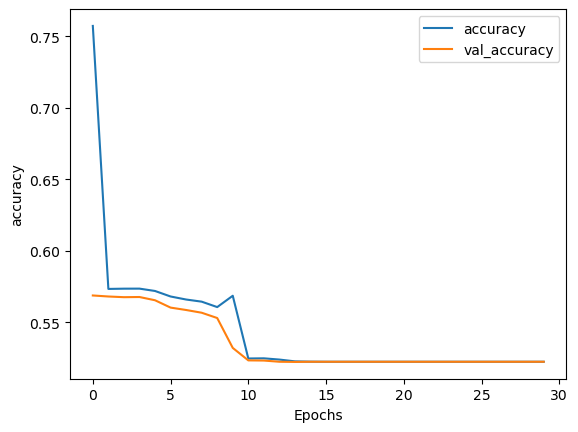

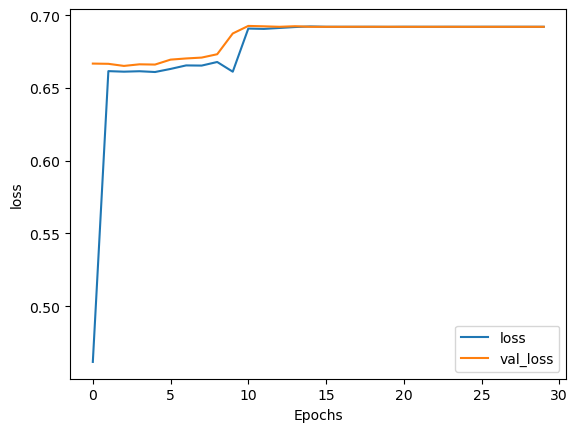

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
rnn_loss, rnn_acc = model.evaluate(testing_padded, testing_labels)

262/262 [==============================] - 2s 6ms/step - loss: 0.6921 - accuracy: 0.5224


### MLP

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 40)           400000    
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense_8 (Dense)             (None, 64)                256064    
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 656,129
Trainable params: 656,129
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
1047/1047 - 4s - loss: 0.2195 - accuracy: 0.9088 - val_loss: 0.1348 - val_accuracy: 0.9492 - 4s/epoch - 4ms/step
Epoch 2/30
1047/1047 - 4s - loss: 0.0932 - accuracy: 0.9660 - val_loss: 0.1337 - val_accuracy: 0.9520 - 4s/epoch - 3ms/step
Epoch 3/30
1047/1047 - 4s - loss: 0.0485 - accuracy: 0.9833 - val_loss: 0.1564 - val_accuracy: 0.9522 - 4s/epoch - 3ms/step
Epoch 4/30
1047/1047 - 3s - loss: 0.0217 - accuracy: 0.9930 - val_loss: 0.2080 - val_accuracy: 0.9480 - 3s/epoch - 3ms/step
Epoch 5/30
1047/1047 - 4s - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.2506 - val_accuracy: 0.9471 - 4s/epoch - 3ms/step
Epoch 6/30
1047/1047 - 4s - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.2898 - val_accuracy: 0.9445 - 4s/epoch - 3ms/step
Epoch 7/30
1047/1047 - 4s - loss: 0.0063 - accuracy: 0.9982 - val_loss: 0.3070 - val_accuracy: 0.9442 - 4s/epoch - 3ms/step
Epoch 8/30
1047/1047 - 4s - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.3475 - val_accuracy: 0.9448 - 4s/epoch - 3ms/step
Epoch 9/

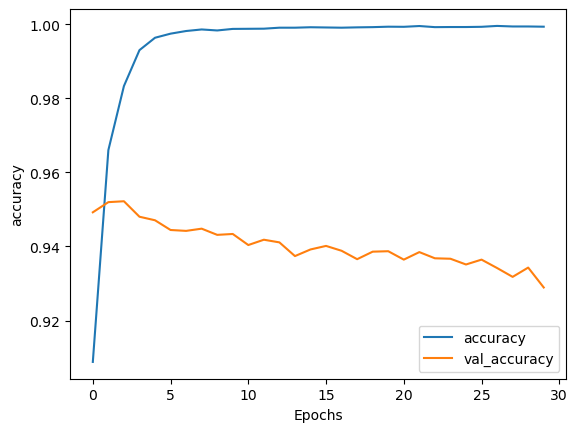

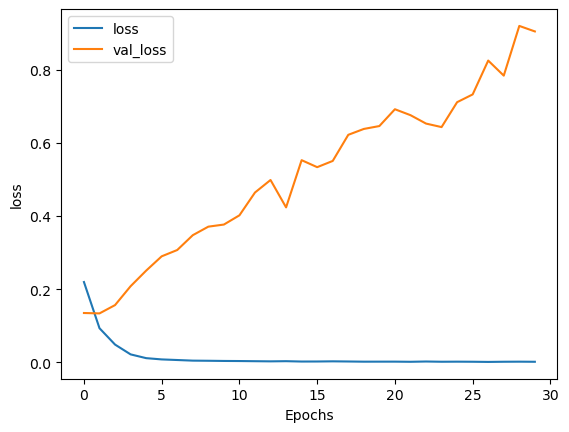

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
mlp_loss, mlp_acc = model.evaluate(testing_padded, testing_labels)

262/262 [==============================] - 0s 1ms/step - loss: 0.9046 - accuracy: 0.9289


### Results

In [ ]:
results_dict = {'LSTM': {'accuracy': lstm_acc, 'loss': lstm_loss},
                'BiLSTM': {'accuracy': bilstm_acc, 'loss': bilstm_loss},
                'CNN': {'accuracy': cnn_acc, 'loss': cnn_loss},
                'RNN': {'accuracy': rnn_acc, 'loss': rnn_loss},
                'MLP': {'accuracy': mlp_acc, 'loss': mlp_loss}}

results_df = pd.DataFrame(results_dict).transpose().sort_values('accuracy', ascending=False)

display(HTML(results_df.to_html()))

,accuracy,loss
CNN,0.944929,0.843847
LSTM,0.941226,0.508058
BiLSTM,0.938478,0.537115
MLP,0.928921,0.904564
RNN,0.522399,0.692145


## Transformer: BERT

In [ ]:
X = df['tweet']
y = df['type']

# Reshape X to a 2D array
X = X.values.reshape(-1, 1)

# Create an instance of the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Perform undersampling on the majority class
X_undersampled, y_undersampled = rus.fit_resample(X, y)

# Flatten the undersampled features to a 1D array
X_undersampled = np.squeeze(X_undersampled)

# Create a new DataFrame with the undersampled data
df1_undersampled = pd.DataFrame({'text': X_undersampled, 'label': y_undersampled})

df1_bert = df1_undersampled[["text","label"]]
df1_bert['label'] = df1_bert['label'].map({'real':0, 'fake':1})
df1_bert.sample(5)

,text,label
19460,ashamed want seize victory years old heroic go...,1
22451,marcel kohler coach first football team al ahl...,0
8580,salmeen makes mistake,1
14875,brother give league,1
11744,verdict,1


In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
data_text = df1_bert["text"]
data_label = df1_bert["label"]

X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

max_length = 100

def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(max_length,),dtype=tf.int32)
    input_mask=Input(shape=(max_length,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

model_bert = create_model()
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [ ]:
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, clipnorm=1.0)
model_bert.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

history = model_bert.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = Y_train, epochs=10, validation_split = 0.2, batch_size = 10, callbacks=[callback])

Epoch 1/10
2559/2559 [==============================] - 15405s 6s/step - loss: 0.1536 - accuracy: 0.9434 - val_loss: 0.1390 - val_accuracy: 0.9556
Epoch 2/10
2559/2559 [==============================] - 11019s 4s/step - loss: 0.0876 - accuracy: 0.9712 - val_loss: 0.1495 - val_accuracy: 0.9537
Epoch 3/10
2559/2559 [==============================] - 10847s 4s/step - loss: 0.0503 - accuracy: 0.9833 - val_loss: 0.1768 - val_accuracy: 0.9537
Epoch 4/10
2559/2559 [==============================] - 10746s 4s/step - loss: 0.0305 - accuracy: 0.9907 - val_loss: 0.1988 - val_accuracy: 0.9633
Epoch 5/10
2559/2559 [==============================] - 12613s 5s/step - loss: 0.0181 - accuracy: 0.9946 - val_loss: 0.2121 - val_accuracy: 0.9611
Epoch 6/10
2559/2559 [==============================] - 16615s 6s/step - loss: 0.0152 - accuracy: 0.9950 - val_loss: 0.2098 - val_accuracy: 0.9567
Epoch 7/10
2559/2559 [==============================] - 20507s 8s/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0

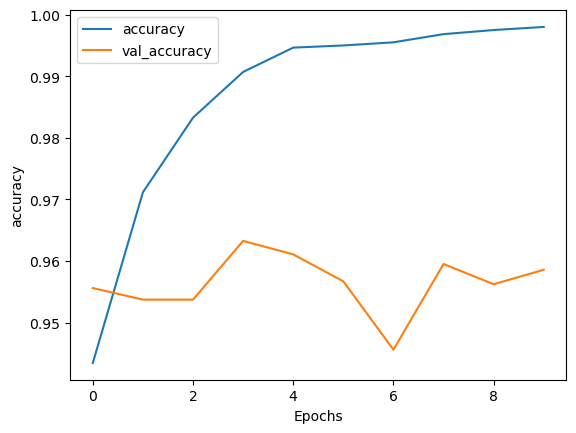

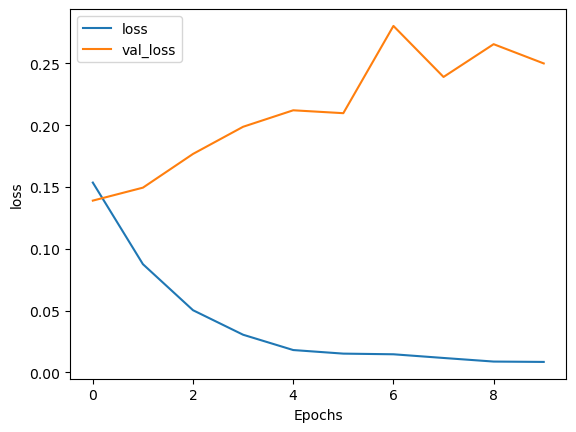

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

250/250 [==============================] - 1274s 5s/step


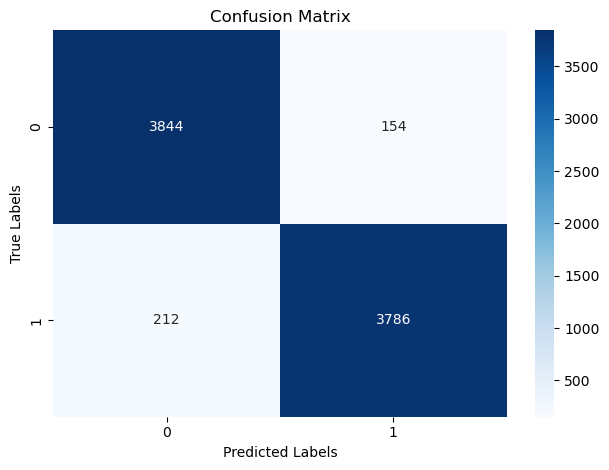

In [ ]:
y_pred = np.where(model_bert.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)

# Compute the confusion matrix
confusion_matrix = confusion_matrix(Y_test, y_pred)

# Create a heatmap of the confusion matrix
ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Set labels, title, and adjust layout
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.tight_layout()

# Display the plot
plt.show()

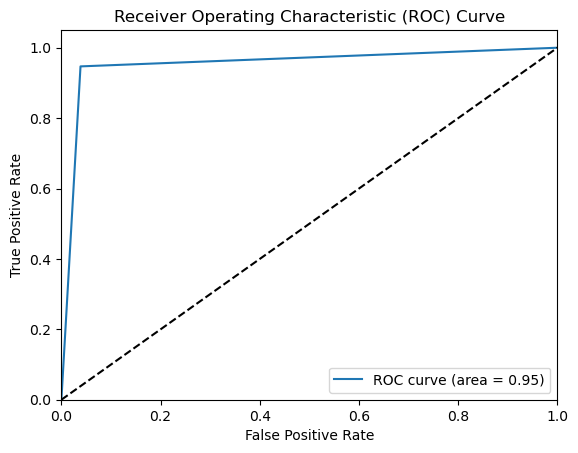

In [ ]:
# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot a diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_bert.evaluate([X_test_token['input_ids'], X_test_token['attention_mask']], Y_test)

# Print the test loss and accuracy
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

250/250 [==============================] - 1308s 5s/step - loss: 0.2822 - accuracy: 0.9542
Test Loss: 0.282186359167099
Test Accuracy: 0.954227089881897


## Interactive window with the best model

In [ ]:
def preprocess_text(text):
    # Tokenize the text
    encoded_text = bert_tokenizer.encode_plus(
        text=text,
        add_special_tokens=True,
        max_length=100,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

    input_ids = encoded_text['input_ids']
    attention_mask = encoded_text['attention_mask']

    return input_ids, attention_mask

# Create a table object
table = PrettyTable()
table.field_names = ["Tweet", "User Label", "Predicted Label"]

tweet_count = 1

# Print the title
print("PREDICTION MODEL FOR FAKE NEWS IN EGYPTIAN FOOTBALL")
print()

while True:

    print("-----------------------------------------------------------------")
    text = input(f"Enter Tweet {tweet_count} (or 'quit' to exit): ")
    if text == "quit":
        break

    label = input("Enter the label (1 for fake, 0 for real): ")
    tokenized_text = tokenize([text])
    predicted_probs = model_bert.predict({'input_1': tokenized_text['input_ids'], 'input_2': tokenized_text['attention_mask']})
    predicted_label = np.where(predicted_probs >= 0.5, 1, 0)

    print()
    print("-----------------------------------------------------------------")
    print()

    if label == "0":
        user_label = "real"
    else:
        user_label = "fake"

    if predicted_label == [[0]]:
        model_label = "real"
    else:
        model_label = "fake"

    print("TWEET", tweet_count)
    print("The user said that the tweet is:", user_label)
    print("The model said that the tweet is:", model_label)
    print()

    # Add the row to the table
    table.add_row([text, user_label, model_label])

    tweet_count += 1

PREDICTION MODEL FOR FAKE NEWS IN EGYPTIAN FOOTBALL

-----------------------------------------------------------------
Enter Tweet 1 (or 'quit' to exit): Real Madrid joined Egyptian league last year
Enter the label (1 for fake, 0 for real): 1
1/1 [==============================] - 0s 144ms/step

-----------------------------------------------------------------

TWEET 1
The user said that the tweet is: fake
The model said that the tweet is: fake

-----------------------------------------------------------------
Enter Tweet 2 (or 'quit' to exit): Mo Salah was married with a monkey
Enter the label (1 for fake, 0 for real): 1
1/1 [==============================] - 0s 144ms/step

-----------------------------------------------------------------

TWEET 2
The user said that the tweet is: fake
The model said that the tweet is: fake

-----------------------------------------------------------------
Enter Tweet 3 (or 'quit' to exit): Mohammad Salah is one of the most successtul Egyptian football

In [ ]:
html_table = table.get_html_string()
display(HTML(html_table))

Tweet,User Label,Predicted Label
Real Madrid joined Egyptian league last year,fake,fake
Mo Salah was married with a monkey,fake,fake
Mohammad Salah is one of the most successtul Egyptian football players ever. He plays for Liverpool and his net worth is estimated to be close to 390 million,real,real
Mo Salah and Magi Salah were blessed with another daughter Kayan in February 2020,real,real
Mo Salah is the current captain of his international team - Egypt. He is quite simply regarded as the best footballer the country has ever showcased.,real,real
"Yesterday, EFA spokesman Ahmed Megahed announced that the EFA had taken into careful consideration all of Salan's comments in order to help improve the conditions for the national team",real,real
Egyptian Football has Rihanna as one of their football players,fake,fake
mo Salah is married!!!,real,real
Real Madrid joined Egyptian league last year,fake,fake
Mo Salah was married with a monkey,fake,fake


# References

references:

@article{shu2018fakenewsnet,
  title={FakeNewsNet: A Data Repository with News Content, Social Context and Dynamic Information for Studying Fake News on Social Media},
  author={Shu, Kai and  Mahudeswaran, Deepak and Wang, Suhang and Lee, Dongwon and Liu, Huan},
  journal={arXiv preprint arXiv:1809.01286},
  year={2018}
}

@article{shu2017fake,
  title={Fake News Detection on Social Media: A Data Mining Perspective},
  author={Shu, Kai and Sliva, Amy and Wang, Suhang and Tang, Jiliang and Liu, Huan},
  journal={ACM SIGKDD Explorations Newsletter},
  volume={19},
  number={1},
  pages={22--36},
  year={2017},
  publisher={ACM}
}

@article{shu2017exploiting,
  title={Exploiting Tri-Relationship for Fake News Detection},
  author={Shu, Kai and Wang, Suhang and Liu, Huan},
  journal={arXiv preprint arXiv:1712.07709},
  year={2017}
}